In [4]:
!pip install datasets transformers

import datasets
import numpy as np
from tqdm.notebook import tqdm_notebook
import torch
import math
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet50_Weights
from torchvision.transforms import Compose, Resize, ToTensor, Pad, ConvertImageDtype, Lambda
import matplotlib.pyplot as plt
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
################################# load, process and split the data #################################
# download the source datasets
imagenette_dataset = datasets.load_dataset("frgfm/imagenette", "full_size", split="train")
diffusion_db_dataset = datasets.load_dataset("poloclub/diffusiondb", "2m_first_10k", split="train")

# delete uneccessary columns
diffuision_columns_to_drop = ['prompt', 'seed', 'step', 'cfg', 'sampler', 'user_name', 'timestamp', 'image_nsfw', 'prompt_nsfw', 'width', 'height']
diffusion_db_dataset = diffusion_db_dataset.remove_columns(diffuision_columns_to_drop)
imagenette_dataset = imagenette_dataset.remove_columns(['label'])

# Add numeric labels to the datasets
diffusion_labels = np.zeros(len(diffusion_db_dataset), dtype=np.int64)
diffusion_labels += 1
diffusion_db_dataset = diffusion_db_dataset.add_column("label", diffusion_labels)

imagenette_label = np.zeros(len(imagenette_dataset), dtype=np.int64)
imagenette_dataset = imagenette_dataset.add_column("label", imagenette_label)

# Create a new features schema with a ClassLabel object
class_label = datasets.ClassLabel(names=['fake', 'real'])
new_features = datasets.Features(
    {
        'image': datasets.Image(),
        'label': class_label
    }
)

diffusion_db_dataset = diffusion_db_dataset.map(lambda example: {'label': class_label.str2int('fake')}, remove_columns=['label'], features=new_features)
imagenette_dataset = imagenette_dataset.map(lambda example: {'label': class_label.str2int('real')}, remove_columns=['label'], features=new_features)

# concatenate both datasets to one
combined_dataset = datasets.concatenate_datasets([imagenette_dataset, diffusion_db_dataset])

# create test, train and validation split and keep class balance
# Split the combined dataset into 80% for train and 20% for a temporary dataset
train_and_temp_splits = combined_dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
train_dataset = train_and_temp_splits['train']

# Split the temporary dataset into 50% test and 50% validation (each will be 7.5% of the original combined dataset)
test_and_validation_splits = train_and_temp_splits['test'].train_test_split(test_size=0.5, seed=42, stratify_by_column="label")
test_dataset = test_and_validation_splits['test']
validation_dataset = test_and_validation_splits['train']

# Create a DatasetDict containing the three splits
dataset = datasets.DatasetDict({"train": train_dataset, "test": test_dataset, "val": validation_dataset})

# print dataset keys and values
for ds in dataset:
    print(ds, dataset[ds])

Generating train split: 0 examples [00:00, ? examples/s]

Dataset diffusiondb downloaded and prepared to /root/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_10k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1. Subsequent calls will reuse this data.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9469 [00:00<?, ? examples/s]

train Dataset({
    features: ['image', 'label'],
    num_rows: 15575
})
test Dataset({
    features: ['image', 'label'],
    num_rows: 1947
})
val Dataset({
    features: ['image', 'label'],
    num_rows: 1947
})


In [6]:
################################# functions to process an element #################################

def get_image_size(combined_dataset):
    # Calculate the aspect ratios and sizes of all images in the combined dataset
    aspect_ratios = []
    sizes = []

    for example in tqdm_notebook(combined_dataset):
        image = example['image']
        height, width = image.size
        aspect_ratios.append(width / height)
        sizes.append((width, height))

    # Compute the median aspect ratio and size
    median_aspect_ratio = np.median(aspect_ratios)
    median_size = np.median(sizes, axis=0)

    # Calculate the new dimensions based on the median aspect ratio
    target_size = 375  # This is the target size (width or height) you want for your images
    new_width = int(target_size * median_aspect_ratio)
    new_height = target_size

    # Check if the width is greater than the height, and adjust accordingly
    if new_width > new_height:
        new_width, new_height = new_height, new_width

    # Calculate padding
    padding_width = (target_size - new_width) // 2
    padding_height = (target_size - new_height) // 2
    return new_width, new_height, padding_width, padding_height

# new_width, new_height, padding_width, padding_height = get_image_size(combined_dataset)
new_width, new_height, padding_width, padding_height = 375, 375, 0, 0
print(new_width, new_height, padding_width, padding_height)

# Function to convert an image to 3 channels
def to_3_channels(image):
    if image.shape[0] == 3:
        return image
    return image.repeat(3, 1, 1)

def collate_fn(examples):
    images, labels = [], []

    image_transform = Compose([
        Lambda(lambda x: x.convert('RGB')),  # Convert all images to RGB
        Resize((new_height, new_width)),
        Pad((padding_width, padding_height, math.ceil(padding_width), math.ceil(padding_height))),
        ToTensor(),
        Lambda(to_3_channels),  # Ensure all images have 3 channels
        ConvertImageDtype(torch.float32)  # Convert image dtype to float32
    ])

    # Iterate through the examples, apply the image transformation, and append the results
    for example in examples:
        image = image_transform(example['image'])
        label = example['label']
        images.append(image)
        labels.append(label)

    # Stack the images and labels
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}


  0%|          | 0/19469 [00:00<?, ?it/s]

375 375 0 0


In [7]:
################################# define the model and parameters #################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 16
batch_size = 32
learning_rate = 0.001

train_dataloader = DataLoader(dataset['train'], collate_fn=collate_fn, batch_size=batch_size)
val_dataloader =  DataLoader(dataset['val'], collate_fn=collate_fn, batch_size=batch_size)

model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

tr = model.train()

train_accu = []
train_losses = []

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


In [9]:
################################# train the model #################################

def train(epoch,data):
    print('\nEpoch : %d'%epoch)
    correct = 0
    running_loss=0
    total=0
    for element in tqdm_notebook(data):
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss=running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

eval_losses=[]
eval_accu=[]

def val(data):
    correct = 0
    running_loss=0
    total=0
    with torch.no_grad():
      for element in data:
          # Move input and label tensors to the device
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss=running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))

for epoch in range(1,num_epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)
  # save the model
  PATH = './resnet50_hannes_v1_{}.pth'.format(epoch)
  torch.save(model.state_dict(), PATH)




Epoch : 1


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.138 | Accuracy: 95.095
Val Loss: 0.101 | Accuracy: 96.353

Epoch : 2


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.083 | Accuracy: 97.008
Val Loss: 0.068 | Accuracy: 97.689

Epoch : 3


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.062 | Accuracy: 97.644
Val Loss: 0.070 | Accuracy: 97.637

Epoch : 4


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.055 | Accuracy: 97.823
Val Loss: 0.102 | Accuracy: 96.764

Epoch : 5


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.042 | Accuracy: 98.395
Val Loss: 0.057 | Accuracy: 97.843

Epoch : 6


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.045 | Accuracy: 98.408
Val Loss: 0.106 | Accuracy: 96.764

Epoch : 7


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.045 | Accuracy: 98.318
Val Loss: 0.063 | Accuracy: 97.894

Epoch : 8


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.034 | Accuracy: 98.690
Val Loss: 0.046 | Accuracy: 98.151

Epoch : 9


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.028 | Accuracy: 99.075
Val Loss: 0.071 | Accuracy: 97.278

Epoch : 10


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.040 | Accuracy: 98.594
Val Loss: 0.059 | Accuracy: 98.048

Epoch : 11


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.023 | Accuracy: 99.307
Val Loss: 0.116 | Accuracy: 96.199

Epoch : 12


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.029 | Accuracy: 99.011
Val Loss: 0.034 | Accuracy: 99.024

Epoch : 13


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.024 | Accuracy: 99.165
Val Loss: 0.060 | Accuracy: 98.202

Epoch : 14


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.027 | Accuracy: 99.088
Val Loss: 0.042 | Accuracy: 98.202

Epoch : 15


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.020 | Accuracy: 99.294
Val Loss: 0.051 | Accuracy: 98.151

Epoch : 16


  0%|          | 0/487 [00:00<?, ?it/s]

Train Loss: 0.013 | Accuracy: 99.544
Val Loss: 0.071 | Accuracy: 98.151


# Neuer Abschnitt

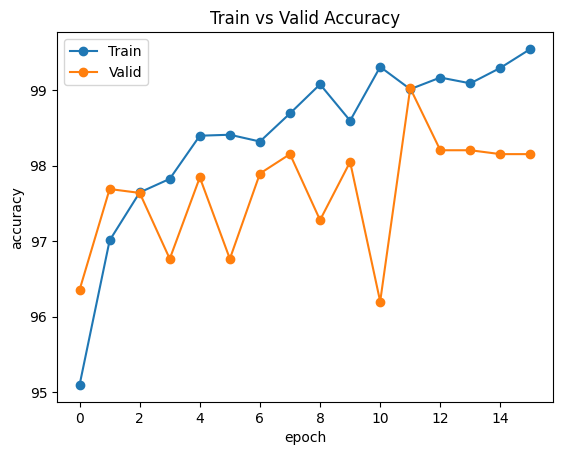

In [10]:
################################# plot trainin stats #################################

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

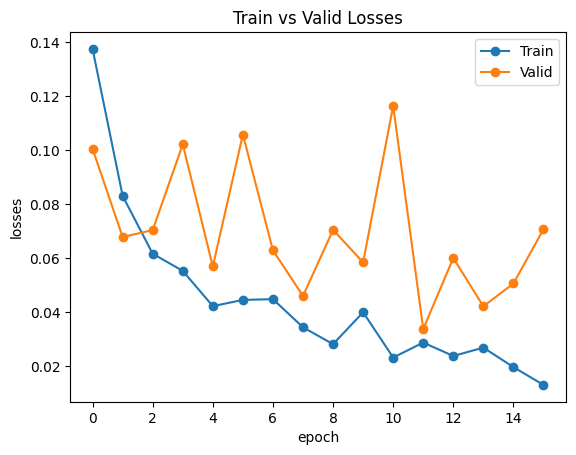

In [11]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [15]:
################################# test the model #################################
model_path = "./resnet50_hannes_v1_13.pth"
model.load_state_dict(torch.load(model_path))

# Create a test dataloader
test_dataloader = DataLoader(dataset['test'], collate_fn=collate_fn, batch_size=batch_size)

def test(data):
    correct = 0
    total = 0
    test_loss = 0
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        for element in tqdm_notebook(data):
            # Move input and label tensors to the device
            inputs = element["pixel_values"].to(device)
            labels = element["label"].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(data)
    accuracy = 100. * correct / total
    print('Test Loss: %.3f | Accuracy: %.3f' % (test_loss, accuracy))

# Test the model on the test set
test(test_dataloader)

  0%|          | 0/61 [00:00<?, ?it/s]

Test Loss: 0.024 | Accuracy: 99.178
